Assignment 4: Identifying Spam Email with a Decision Tree (Random Forest) model 

This is more of a tutorial than an Assignment.  I have written most of the code.  I would like you to be familiar with this, without using class time. This approach is likely to be useful for your final project. 

There is is an important new method in here called GridSearchCV.  Its a generic tool to allow you optimize hyperparameters with an sklearn model. 

We will be working with a spam email dataset. The dataset has 57 predictors with a response variable called `Spam` that indicates whether an email is spam or not spam. The goal is to be able to create a classifier or method that acts as a spam filter.

In [29]:
# imports
import numpy as np
import pandas as pd
from scipy.stats import gamma
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.inspection import permutation_importance
from sklearn.inspection import partial_dependence


In [2]:
#Import Dataframe and get Column Names
spam_df = pd.read_csv('spambase.csv')
columns = spam_df.columns.tolist()

In [3]:
spam_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4601 entries, 0 to 4600
Data columns (total 58 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   word_freq_make              4601 non-null   float64
 1   word_freq_address           4601 non-null   float64
 2   word_freq_all               4601 non-null   float64
 3   word_freq_3d                4601 non-null   float64
 4   word_freq_our               4601 non-null   float64
 5   word_freq_over              4601 non-null   float64
 6   word_freq_remove            4601 non-null   float64
 7   word_freq_internet          4601 non-null   float64
 8   word_freq_order             4601 non-null   float64
 9   word_freq_mail              4601 non-null   float64
 10  word_freq_receive           4601 non-null   float64
 11  word_freq_will              4601 non-null   float64
 12  word_freq_people            4601 non-null   float64
 13  word_freq_report            4601 

The predictors are all continuous: 

- 48 continuous real [0,100] attributes of type word_freq_WORD 

    - percentage of words in the e-mail that match WORD, i.e. 100 * (number of times the WORD appears in the e-mail) / total number of words in e-mail.  A "word" in this case is any string of alphanumeric characters bounded by non-alphanumeric characters or end-of-string.


- 6 continuous real [0,100] attributes of type char_freq_CHAR


- 3 continuous real [1,...] attribute of type capital_run_length_* 

    - **average** length of uninterrupted sequences of capital letters
    - length of **longest** uninterrupted sequence of capital letters
    - **total** number of capital letters in the e-mail

- 1 nominal {0,1} class attribute of type spam
    - denotes whether the e-mail was considered spam (1) or not (0), i.e. unsolicited commercial e-mail. 

Link to description : https://archive.ics.uci.edu/ml/datasets/spambase 

Let us split the dataset into a 70-30 test-train splot.  In order to make 

In [26]:
spam_train, spam_test = train_test_split(spam_df, test_size=0.3, random_state=222, stratify=spam_df['spam'])

We can check that the number of spam cases is roughly evenly represented in both the training and test set.

In [27]:
#Check Percentage of Spam in Train and Test Set
pct_spam_tr = 100*spam_train['spam'].mean()
pct_spam_te = 100*spam_test['spam'].mean()
                                                  
print(f"Percentage of Spam in Training Set \t : {pct_spam_tr:0.2f}%")
print(f"Percentage of Spam in Testing Set \t : {pct_spam_te:0.2f}%")

Percentage of Spam in Training Set 	 : 39.41%
Percentage of Spam in Testing Set 	 : 39.39%


EDA: 
With 57 predictors, a pairplot becomes difficult to look at. 
Two things that are worth doing, are to compute the means (or medians) of each predictor grouped by the spamlabels 


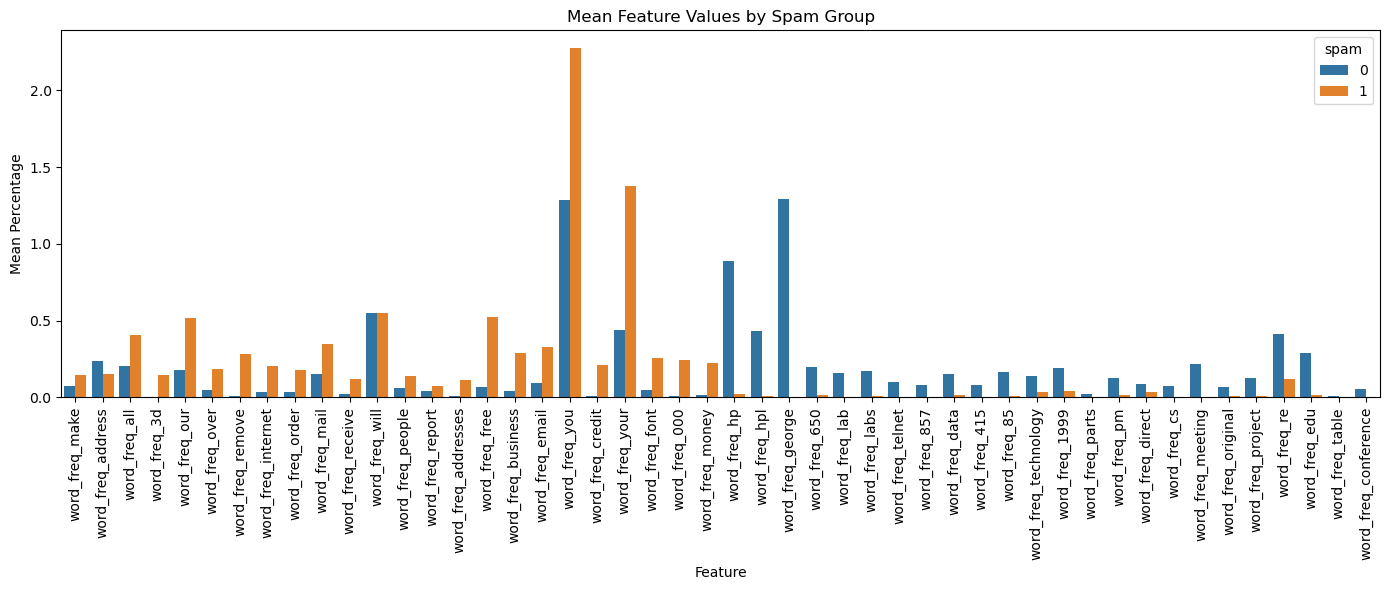

In [24]:
# Compute means per group
x = spam_train.groupby('spam').mean()
#Lets limit to first 53 features for better visualization as they are on same scale
x = x.iloc[:, :48].reset_index()
# Convert to long form for plotting
x_melt = x.melt(id_vars='spam', var_name='feature', value_name='mean')

# Plot
plt.figure(figsize=(14,6))
sns.barplot(data=x_melt, x='feature', y='mean', hue='spam', dodge=True)
plt.title('Mean Feature Values by Spam Group')
plt.xlabel('Feature')
plt.ylabel('Mean Percentage')
plt.xticks(columns[0:48],rotation=90)
plt.tight_layout()
plt.show()

make a similar bar plot for the remaining predictor variables, grouped by variable types into different plots, as they will tend to be on the same scale. 

,state,fipscode,county,population,hispanic,minority,female,unemployed,income,nodegree,bachelor,inactivity,obesity,density,cancer,votergap,trump,clinton
0,Colorado,8117,Summit County,27239,15.173,4.918,45.996,2.5,68352,5.4,48.1,8.1,13.1,46.0,46.2,-27.632,31.530,59.162
1,Colorado,8037,Eagle County,53653,30.040,5.169,47.231,3.1,76661,10.1,47.3,9.4,11.8,31.0,47.1,-19.897,36.058,55.955
2,Idaho,16067,Minidoka County,19226,34.070,5.611,49.318,3.7,46332,24.1,11.8,18.3,34.2,80.0,61.8,54.148,71.135,16.987
3,Colorado,8113,San Miguel County,7558,10.154,4.747,46.808,3.7,59603,4.7,54.4,12.4,16.7,5.7,62.6,-44.769,23.892,68.662
4,Utah,49051,Wasatch County,21600,13.244,4.125,48.812,3.4,65207,9.5,34.4,13.9,23.0,257.8,68.3,25.357,50.471,25.114


Do I need to use standard scaler?  Why or why not? 

One of the advantages of a decision tree model is that the 

In [ ]:


# Split features and target
X_train = spam_train.drop(columns=['spam'])
y_train = spam_train['spam']

# Base model
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
)

# Parameter grid – only max_depth
param_grid = {'max_depth': [2,3,4,5,6,7,8]}

# Grid search — GridSearchCV will perform 5-fold Stratified CV automatically
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='accuracy',# of metric: 'roc_auc', 'accuracy', etc.
    cv=5,          # number of folds
    n_jobs=-1,
)

# Fit
grid_search.fit(X_train, y_train)

print("Best max_depth:", grid_search.best_params_['max_depth'])
print("Best Accuracy:", grid_search.best_score_)

best_rf = grid_search.best_estimator_   #This is the best model as a sklearn object that you can use to make predictions on the test data. 


Best max_depth: 8
Best Accuracy: 0.9381987577639752


Exception ignored in: <function ResourceTracker.__del__ at 0x7f9de378a660>
Traceback (most recent call last):
  File "/home/ramesh/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/ramesh/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/ramesh/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7fd4c1582660>
Traceback (most recent call last):
  File "/home/ramesh/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/ramesh/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/ramesh/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__

In this example the best max_depth was 8 with a cross-validation accuracy of 93 %, althugh that seems very good, its worth noting that 8 was the highest depth we tested,  It could be better to test more depth.  Another (reaosnable) possibiliy is that our number of trees is too low.  We can use GridSearchCV to search over multiple parameters by extending the param_grid dicionary 

param_grid = {'max_depth': npa.range(5,40,5), 'n_estimators' : np.arange(200,1000,200)}

Dont forget to remove n_estimators from your base model for RandomForestClassifier

In [42]:
# Split features and target
X = spam_train.drop(columns=['spam'])
y = spam_train['spam']

# Base model
rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
)

# Parameter grid – max_depth and n_estimators

param_grid = param_grid = {'max_depth': np.arange(10,60,5), 'n_estimators' : np.arange(200,1000,200)}

# Grid search — GridSearchCV will perform 5-fold Stratified CV automatically
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='accuracy',# of metric: 'roc_auc', 'accuracy', etc.
    cv=5,          # number of folds
    n_jobs=-1,
)

# Fit
grid_search.fit(X, y)

print("Best max_depth:", grid_search.best_params_['max_depth'])
print("Best n_estimators:", grid_search.best_params_['n_estimators'])

print("Best Accuracy:", grid_search.best_score_)

best_rf = grid_search.best_estimator_

Best max_depth: 30
Best n_estimators: 200
Best Accuracy: 0.9546583850931677


Deeper trees take longer to run, more trees take longer to run.  At some point, you have reached a plateau.  In my case, i gor the performance > 0.95 and I was not choosing the highest or lowest parameter values.  

Make use of the best model to evaluate the test data 

In [43]:
X_test = spam_test.drop(columns=['spam'])
y_test = spam_test['spam']

best_rf.score(X_test, y_test)

0.9478638667632151

Exception ignored in: <function ResourceTracker.__del__ at 0x7f126c98a660>
Traceback (most recent call last):
  File "/home/ramesh/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/ramesh/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/ramesh/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7f97eb786660>
Traceback (most recent call last):
  File "/home/ramesh/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/ramesh/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/ramesh/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__

It does really well!   How did it do it.   Depending on your choices, I suspect you have a tree with a lot of depth and many trees. 

You can make use of partial dependence scores to evaluate the importance of each parameter.  I would put it in a loop and compute the partial dependence score for each parameter.  Note that partial dependence is computed on t

How do I identify the important parameters to visualize? 

- identify the predictors which have the highest or lowest partial dependence (probability) for spam.  Values of partial dependence close to 1 implies that for those values of the predictor there is a high probabilty of spam.  Values close to zero imply strong evidence of not spam.  

Make a bar plot that shows the highest and lowest prediction probability for each predictor

For example, here i take the first predictor, and compute its partial dependence 

In [71]:
from sklearn.inspection import partial_dependence
predictions = partial_dependence(best_rf, X,features = [51],kind = 'average' )

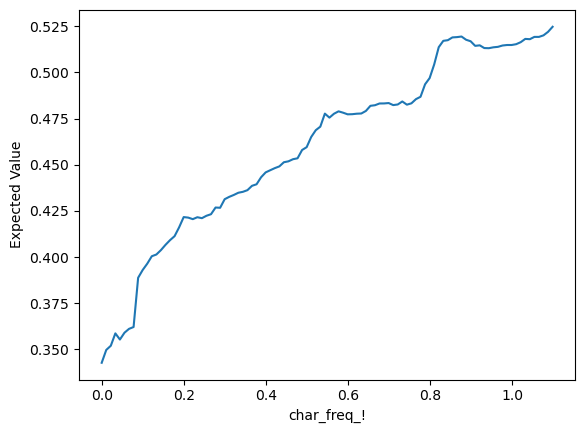

In [73]:
plt.plot(predictions['grid_values'][0],predictions['average'][0])
plt.xlabel(columns[51])
plt.ylabel('Expected Value')
plt.show()

In [57]:
allpredictions = []
allmaxvalues = []
allminvalues = []
allranges = []
for j in range(57):
    predictions = partial_dependence(best_rf, X,features = [j],kind = 'average' )
    allpredictions.append(predictions)
    allmaxvalues.append(np.max(predictions['average'][0]))
    allminvalues.append(np.min(predictions['average'][0]))
    allranges.append(np.max(predictions['average'][0]) - np.min(predictions['average'][0]))

Note: This might take 10+ minutes

([<matplotlib.axis.XTick at 0x7f8e69bcb110>,
 [Text(0.0, 0, 'word_freq_make'),
  Text(1.0, 0, 'word_freq_address'),
  Text(2.0, 0, 'word_freq_all'),
  Text(3.0, 0, 'word_freq_3d'),
  Text(4.0, 0, 'word_freq_our'),
  Text(5.0, 0, 'word_freq_over'),
  Text(6.0, 0, 'word_freq_remove'),
  Text(7.0, 0, 'word_freq_internet'),
  Text(8.0, 0, 'word_freq_order'),
  Text(9.0, 0, 'word_freq_mail'),
  Text(10.0, 0, 'word_freq_receive'),
  Text(11.0, 0, 'word_freq_will'),
  Text(12.0, 0, 'word_freq_people'),
  Text(13.0, 0, 'word_freq_report'),
  Text(14.0, 0, 'word_freq_addresses'),
  Text(15.0, 0, 'word_freq_free'),
  Text(16.0, 0, 'word_freq_business'),
  Text(17.0, 0, 'word_freq_email'),
  Text(18.0, 0, 'word_freq_you'),
  Text(19.0, 0, 'word_freq_credit'),
  Text(20.0, 0, 'word_freq_your'),
  Text(21.0, 0, 'word_freq_font'),
  Text(22.0, 0, 'word_freq_000'),
  Text(23.0, 0, 'word_freq_money'),
  Text(24.0, 0, 'word_freq_hp'),
  Text(25.0, 0, 'word_freq_hpl'),
  Text(26.0, 0, 'word_freq_george'

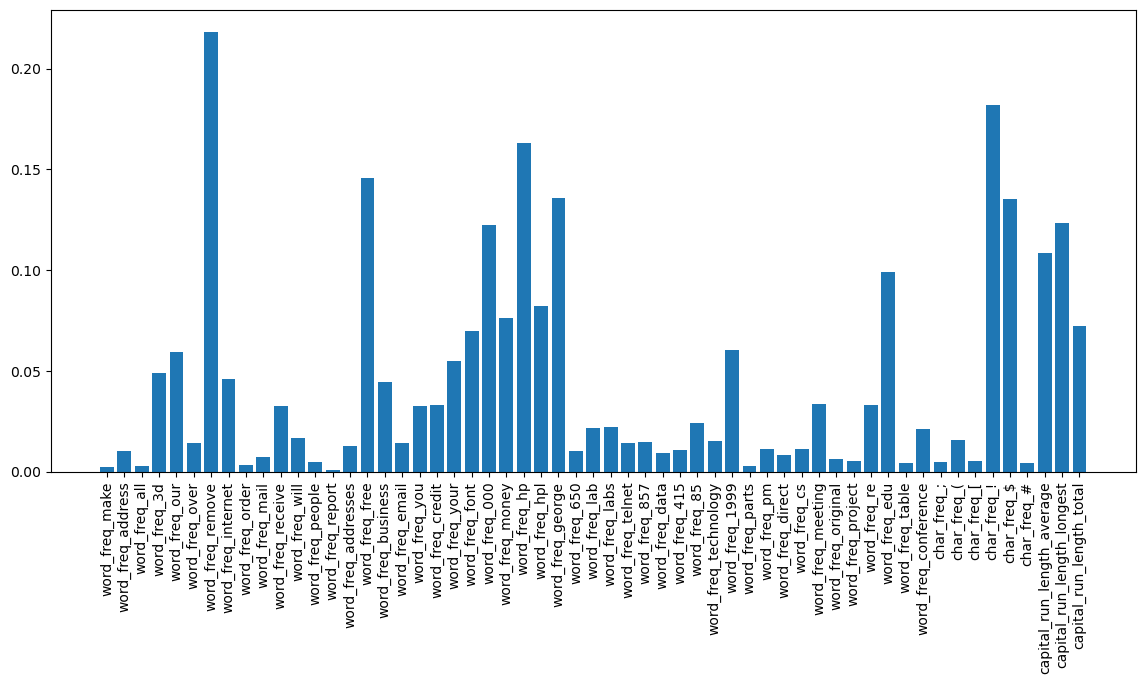

In [67]:
plt.figure(figsize=(14,6))
plt.bar(columns[0:57], allranges)
plt.xticks(columns[0:57],rotation=90)